# SETUP

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob

In [2]:
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

## Loading `notmnist` dataset

In [3]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: user 2.18 s, sys: 365 ms, total: 2.54 s
Wall time: 3.19 s


# Size of train and test datasets

In [4]:
print("Size of train dataset: ", X_train.shape)
print("Size of test dataset: ", X_test.shape)

Size of train dataset:  (14043, 784)
Size of test dataset:  (4681, 784)


# Verifying that classes are balanced

In [5]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1404, 1405, 1405, 1405, 1404, 1404, 1404, 1404, 1404]))

# Visualization

In [6]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

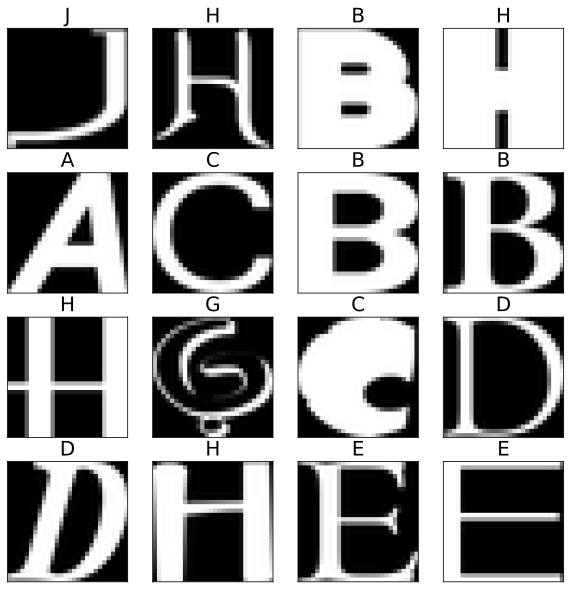

In [7]:
plot_letters(X_train, y_train, random_state=912)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# Making instance of the model
logisticRegr = LogisticRegression()